### Intro

This is an ipython notebook that is runnable from the cloud.   Each cell in the notbook can be run seperately by clicking on it and hitting ctrl+enter.   Once a cell is run, all the global variables are saved, so you can run other cells using variable you've already initialized.

First thing you should do is run all the cell by either hitting ctrl+enter for each cell or by choosing **Kernel** and **Restart and run all** from the menu above.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Random model code

This section contains functions to generate random monotic models.

In [2]:
def monotonic_pairs(max_dist, seed = None):
    # This function will generate a list of pairs
    # List in form of (x,y), where y is monotonicly decreasing.
    # 0<=x<=1.   0<y.   List includes (1,0) and (0,1).
    # The function is assumed to be piecewise linear.
    # max_dist >= xi-x_(i-1)
    if seed is not None:
        random.seed(seed)
    return random_seq(max_dist, 0,1, 0,1)
        

def random_point(x_min, x_max, y_min, y_max):
    return (random.uniform(x_min, x_max), random.uniform(y_min, y_max))

def random_seq(max_dist, x_min, x_max, y_min, y_max):
    x_mid, y_mid= random_point(x_min, x_max, y_min, y_max)
    if x_max-x_min < max_dist:
        return [(x_mid, y_mid)]
    else:
        return random_seq(max_dist, x_min, x_mid, y_mid, y_max) + \
                    [(x_mid, y_mid)] + \
                    random_seq(max_dist, x_mid, x_max, y_min, y_mid)


def plot_pairs(pairs):
    x,y = zip(*pairs)
    plt.plot(x,y)

def get_monotoic_vals(shells):
    # This function will generate a random sequence with monotonic pairs,
    # then sample it to have exactly the number of points requested.  Linear interpolation.
    # @param num:  Number of points.   
    #
    # Note that the last point will always be (1,0)
    
    # Make sure we have enough points.  

    # TODO:   This is a hack
    # Can do better to make sure each point is separate.   Not sure it makes a difference.
    num = len(shells)
    pairs = monotonic_pairs(0.5/num)
    
    x,y = zip(*pairs)
    return np.interp(shells,x,y)

def plot_model(model):
    plt.plot(model[0], model[1])

In [3]:
# Uncomment below lines to see examples:

#for _ in range(10):
#    plot_pairs(monotonic_pairs(0.01))
#    plt.figure()

### Normalization code

These two functions compute the amount of mass/moment per shell.   Right now, we only support a fixed density.

$ mass = 4\pi\rho\int_{r_1}^{r_2}r^2dr = \dfrac{4\pi}{3}\Big[r_2^3-r_1^3\Big]\rho$

$ moment = \dfrac{2}{3}MR^2 = \dfrac{8\pi}{3}\rho\int_{r_1}^{r_2}r^4dr = \dfrac{8\pi}{15}\Big[r_2^5-r_1^5\Big]\rho$

Thus, given a series of fixed shells with radius $r_i$, there is a series of fixed coefficients $M_i$ and $I_i$ such that:

$ mass = \vec{M}\vec{\rho} $

$ moment =  \vec{I}\vec{\rho} $


**Note:** I believe the fixed coefficients also hold with linear density (though the general equations to compute the mass/moment might be a bit more involved).

The advantage of this method is that if we have two solutions $\vec{\rho_1}$ and $\vec{\rho_2}$, any linear combination of the two solution will also have the same mass/moment.   This allows us to fix yet another variable (e.g. J2) with binary search.

In [4]:
def get_mass_coefficient(rad1, rad2, fixed_density=True):
    if not fixed_density:
        raise NotImplemented("Linear density not implmeneted yet.")
    return 4.0/3.0 * np.pi * (np.power(rad2,3.0) - np.power(rad1, 3.0))
        
        
def get_moment_coefficient(rad1, rad2, fixed_density=True):
    if not fixed_density:
        raise NotImplemented("Linear density not implemented yet.")
    return 8.0/15.0 * np.pi * (np.power(rad2,5.0) - np.power(rad1, 5.0))


def compute_mass(model, fixed_density=True):
    # @param model: This is two arrays, first with outer radii, second with densities
    radii, densities = model
    outer = radii
    inner= np.append([0], radii)
    ranges = zip(inner, outer)
        
    coefficients = [get_mass_coefficient(rad1, rad2, fixed_density) 
                    for (rad1, rad2) in ranges]
        
    return np.array(coefficients).dot(densities)

def compute_moment(model, fixed_density=True):
    # @param model: This is two arrays, first with outer radii, second with densities
    radii, densities = model
    outer = radii
    inner= np.append([0], radii)
    ranges = zip(inner, outer)
        
    coefficients = [get_moment_coefficient(rad1, rad2, fixed_density) 
                    for (rad1, rad2) in ranges]
        
    return np.array(coefficients).dot(densities)

In [5]:
class MCPlanet(object):
    def __init__(self, mass, moment, radius, shells=None, num_shells = 100, fixed_density=True):
        # TODO:   Need to think about/ document units.
        self._mass = mass
        self._moment = moment
        self._use_fixed = fixed_density
        self._radius = radius
    
        # Can pass in units as increasing list of radii.
        # Shells are the outer radius of the shells.   Assume shell are touching.
        # num_shells ignored in this case.
        if shells is None:
            self._shells = self._create_radii(num_shells)
        else:
            self._shells = np.array(shells)
            
        self._num_shells = len(self._shells)
    
    def _create_radii(self, num_shells):
        # For now, just equal radii for each shell.
        return (np.array(range(num_shells))+1)/float(num_shells)*self._radius
       
    def _normalize_mass(self, model_points):
        # Assume that our current model is (x,y)
        # Where x is the outer radius (first is zero)
        # And y is the density.   
        #
        # We need to normalize so we match the total mass
        outer = self._shells
        inner= np.append([0], self._shells)
        ranges = zip(inner, outer)
        
        coefficients = [get_mass_coefficient(rad1, rad2, self._use_fixed) 
                        for (rad1, rad2) in ranges]
        
        mass = np.array(coefficients).dot(model_points)
        return model_points*self._mass/mass
    
    def _normalize_moment(self, model_points):
        # Assume that our current model is (x,y)
        # Where x is the outer radius (first is zero)
        # And y is the density.   
        #
        # We need to normalize so we match the total mass
        outer = self._shells
        inner= np.append([0], self._shells)
        ranges = zip(inner, outer)
        
        coefficients = [get_moment_coefficient(rad1, rad2, self._use_fixed) 
                        for (rad1, rad2) in ranges]
        
        moment = np.array(coefficients).dot(model_points)
        return model_points*self._moment/moment
        
        
    def create_mass_model(self, seed=None):
        # first generate random monotonic-path
        model = get_monotoic_vals(self._shells/self._radius)
        return self._shells, self._normalize_mass(model)
                 
        
    def create_moment_model(self, seed=None):
        # first generate random monotonic-path
        model = get_monotoic_vals(self._shells/self._radius)
        return self._shells, self._normalize_moment(model)
    
    
    def create_mass_and_moment_model(self, num_samples = 100, seed=None):
        # We're going to create a model that matches both mass and moment.
        #
        # First, we'll genreate a bunch (100 by default) models and 
        # normalize them so they have the correct mass.
        #
        # Next, we'll compute the moment for each one and divide them into 
        # two groups.    "bigger_moment" and "smaller_moment".
        #
        # Next, we'll randomly choose one model from each set and find the 
        # linear interpolation that will give us a the desired moment.   
        # This interpolated model should have both the correct mass and moment.
        
        models = [self.create_mass_model(seed) for _ in range(num_samples)]
        moments = [compute_moment(model, self._use_fixed) for model in models]
        
        print("%s models generated"%num_samples)
        print("Largest Moment: %s"%max(moments))
        print("Smallest Moment: %s\n\n"%min(moments))
        
        bigger_moment = list(filter(lambda x: x[0] >= self._moment, zip(moments, models)))
        smaller_moment = list(filter(lambda x: x[0] < self._moment, zip(moments, models)))
       
        print("Generated %s bigger moments and %s smaller moments\n\n"%(len(bigger_moment), len(smaller_moment)))
        
        if 0 == len(bigger_moment) or 0 == len(smaller_moment):
            print("WARNING:: Did not manage to create models with moments bracketing desired result.   Exiting.")
            print("Try running again?\n\n")
            return self._shells, 0*models[0][1]
        
        bigger = random.choice(bigger_moment)
        smaller = random.choice(smaller_moment)
        alpha = (self._moment-smaller[0])/(bigger[0]-smaller[0])
        
        return self._shells, alpha*bigger[1][1] + (1.0-alpha)*smaller[1][1]
        

100 models generated
Largest Moment: 9.62048144222353e+44
Smallest Moment: 7.759312195838161e+43


Generated 26 bigger moments and 74 smaller moments


[6.400e+06 1.280e+07 1.920e+07 2.560e+07 3.200e+07 3.840e+07 4.480e+07
 5.120e+07 5.760e+07 6.400e+07 7.040e+07 7.680e+07 8.320e+07 8.960e+07
 9.600e+07 1.024e+08 1.088e+08 1.152e+08 1.216e+08 1.280e+08 1.344e+08
 1.408e+08 1.472e+08 1.536e+08 1.600e+08 1.664e+08 1.728e+08 1.792e+08
 1.856e+08 1.920e+08 1.984e+08 2.048e+08 2.112e+08 2.176e+08 2.240e+08
 2.304e+08 2.368e+08 2.432e+08 2.496e+08 2.560e+08 2.624e+08 2.688e+08
 2.752e+08 2.816e+08 2.880e+08 2.944e+08 3.008e+08 3.072e+08 3.136e+08
 3.200e+08 3.264e+08 3.328e+08 3.392e+08 3.456e+08 3.520e+08 3.584e+08
 3.648e+08 3.712e+08 3.776e+08 3.840e+08 3.904e+08 3.968e+08 4.032e+08
 4.096e+08 4.160e+08 4.224e+08 4.288e+08 4.352e+08 4.416e+08 4.480e+08
 4.544e+08 4.608e+08 4.672e+08 4.736e+08 4.800e+08 4.864e+08 4.928e+08
 4.992e+08 5.056e+08 5.120e+08 5.184e+08 5.248e+08 5.312e+08 5.376e

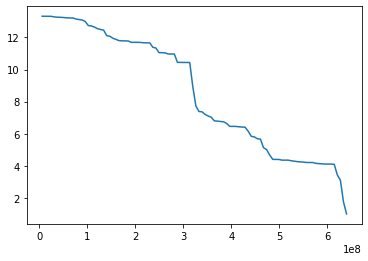

In [6]:
aa= MCPlanet(mass = 6e27, moment= 8e44, radius = 6.4e8, num_shells=100)
model = aa.create_mass_and_moment_model()
print(model[0])
print(model[1])
plot_model(model)

In [7]:
compute_mass(model)

6e+27

In [8]:
compute_moment(model)

8e+44